In [51]:
import pandas as pd
import numpy as np
np.random.seed(1907)

#For classification
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#For visualisation
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

#To remove stopwords
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

#Remove stopwords for easier parsing afterwards
stop_words = list(stopwords.words("english"))

df = pd.read_csv("../../data/abstract_dataset_clean.csv")
df.head(3)

[nltk_data] Downloading package stopwords to /home/theo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Unnamed: 0,title,doi,abstract,task
0,0,Reducing the Hausdorff Distance in Medical Ima...,https://doi.org/10.1109/tmi.2019.2930068,the hausdorff distance hd is widely used in ev...,Prostate
1,1,A multi-model deep convolutional neural networ...,https://doi.org/10.1016/j.neuroimage.2019.116459,alzheimers disease ad is a progressive and irr...,Brain
2,2,Unsupervised Bidirectional Cross-Modality Adap...,https://doi.org/10.1109/tmi.2020.2972701,unsupervised domain adaptation has increasingl...,Cardiac


## Data Analysis

### Task representation

<AxesSubplot: xlabel='count', ylabel='task'>

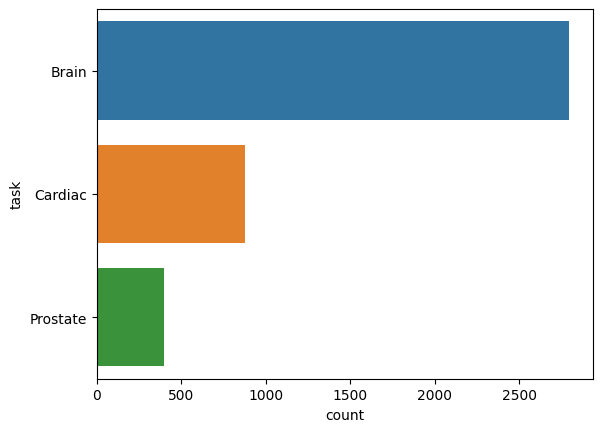

In [27]:
sns.countplot(data=df,y='task',order=df["task"].value_counts().index)

Note: imbalanced class distribution , not a lot of exemples for Prostate class

### Wordcloud per task without tf-idf

Plot of most frequent word in paper abstracts for each task

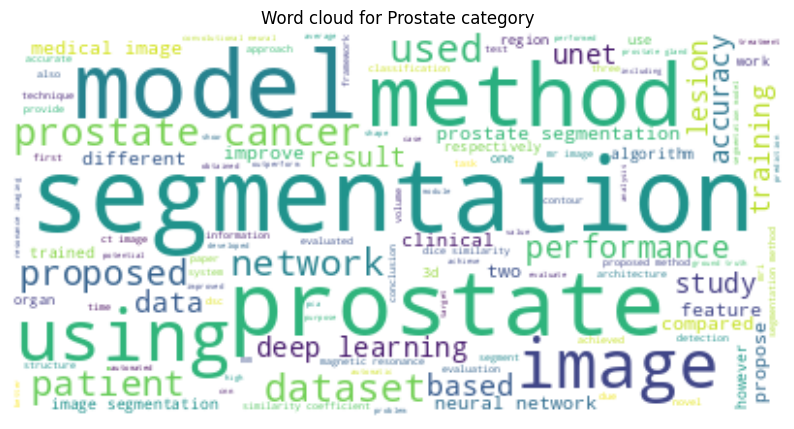

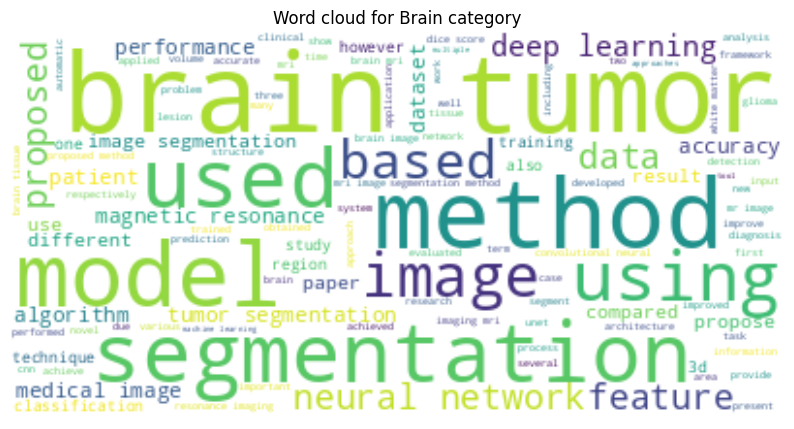

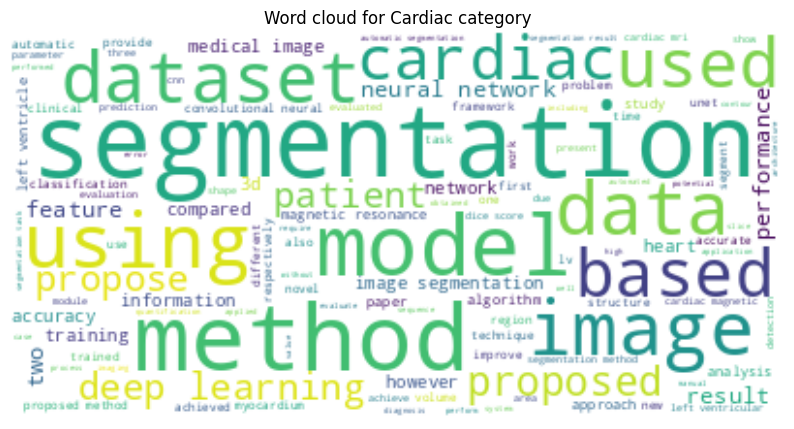

In [18]:
for task in df["task"].unique():
    #Get text of the category
    task_df = df[df["task"]==task]
    text = ' '.join(task_df["abstract"])

    #Plot
    wordcloud = WordCloud(stopwords=stop_words,background_color="white").generate(text)
    
    plt.figure(figsize=(10,10))
    plt.title(f"Word cloud for {task} category")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

### Wordcloud per task with tf-idf

Plot of most frequent word in paper abstracts for each task using tf-idf over the whole dataset (not 1 tf-idf per task)

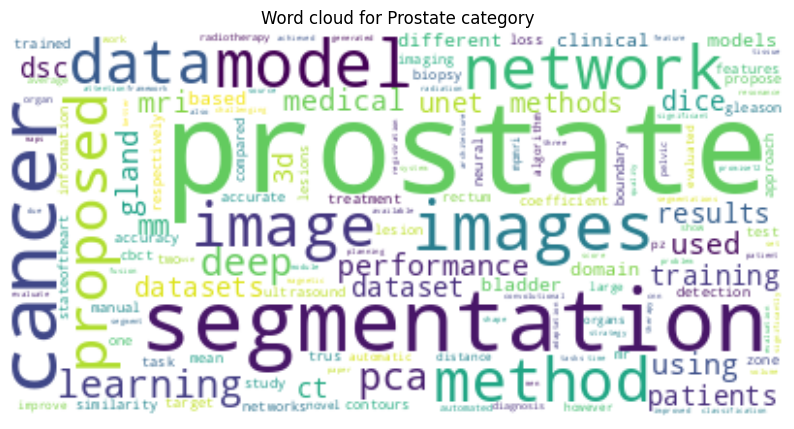

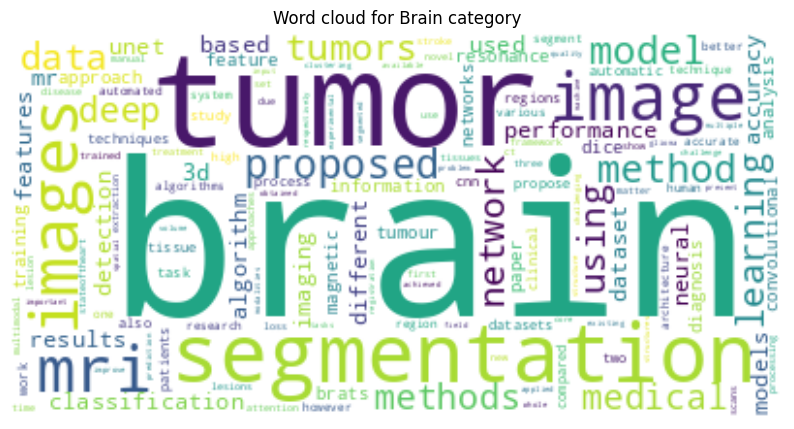

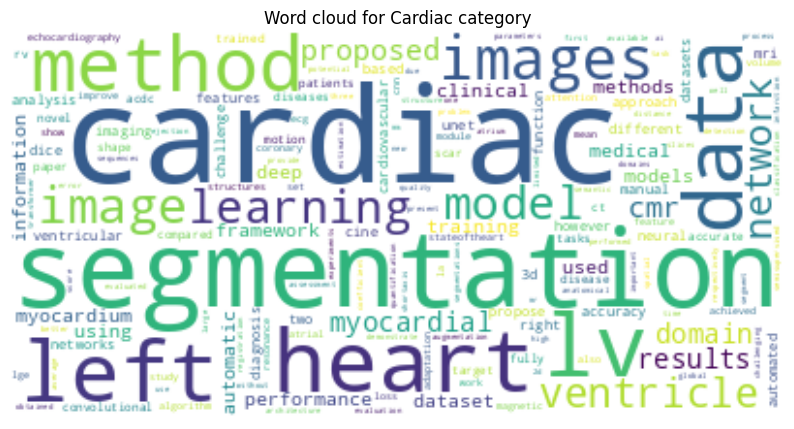

In [2]:
corpus = df["abstract"].to_list()
vectorizer = TfidfVectorizer(stop_words=stop_words)
vecs = vectorizer.fit(corpus)
feature_names = vectorizer.get_feature_names_out()

for task in df["task"].unique():
    #Get text of the category
    task_df = df[df["task"]==task]
    corpus = task_df["abstract"].to_list()
    vecs = vectorizer.transform(corpus)
    vecs = vecs.todense()
    lst1 = vecs.tolist()
    df_tf_idf = pd.DataFrame(lst1, columns=feature_names)

    x = df_tf_idf.T.sum(axis=1)
    #Plot
    wordcloud = WordCloud(stopwords=stop_words,background_color="white").generate_from_frequencies(x)
    
    plt.figure(figsize=(10,10))
    plt.title(f"Word cloud for {task} category")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

## Multi-class Classification with TF-IDF representation and keeping paper with multiple dataset

In [52]:
np.random.seed(1907)

train,test = train_test_split(df,test_size=0.2)
test,dev = train_test_split(test,test_size=0.5)

X_train = train["abstract"].to_list()
X_dev = dev["abstract"].to_list()
X_test = test["abstract"].to_list()

y_train = train["task"].to_list()
y_dev = dev["task"].to_list()
y_test = test["task"].to_list()

vectorizer = TfidfVectorizer(max_features=50,stop_words=stop_words)
vectorizer.fit(X_train)
X_train_tf = vectorizer.transform(X_train)
X_dev_tf = vectorizer.transform(X_dev)
X_test_tf = vectorizer.transform(X_test)


rf_classifier = RandomForestClassifier(n_estimators=200)
rf_classifier.fit(X_train_tf,y_train)

RandomForestClassifier(n_estimators=200)

### List of words selected with TF-IDF

In [53]:
print(vectorizer.get_feature_names_out())

['3d' 'accuracy' 'algorithm' 'analysis' 'approach' 'automatic' 'based'
 'brain' 'cardiac' 'classification' 'clinical' 'compared' 'data' 'dataset'
 'datasets' 'deep' 'detection' 'dice' 'different' 'features' 'however'
 'image' 'images' 'imaging' 'information' 'learning' 'magnetic' 'medical'
 'method' 'methods' 'model' 'models' 'mri' 'network' 'networks' 'neural'
 'paper' 'patients' 'performance' 'proposed' 'resonance' 'results'
 'segmentation' 'study' 'training' 'tumor' 'two' 'unet' 'used' 'using']


### Error Analysis

Train accuracy: 0.9434889434889435


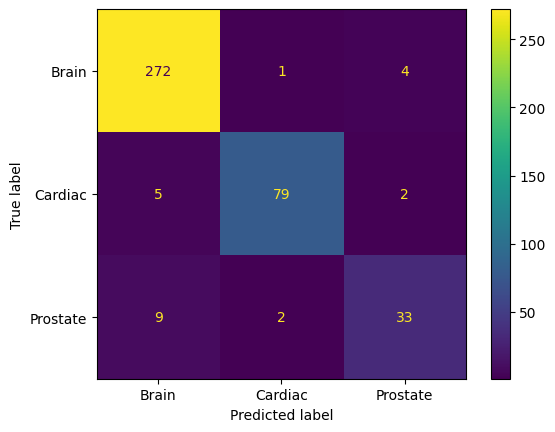

In [54]:
print(f"Train accuracy: {rf_classifier.score(X_dev_tf,y_dev)}")
y_pred = rf_classifier.predict(X_dev_tf)

cm = confusion_matrix(y_dev,y_pred)
disp = ConfusionMatrixDisplay(cm,display_labels=rf_classifier.classes_)
disp.plot()

### Removing papers with multiple datasets

In [55]:
np.random.seed(1907)

df_unique = df.drop_duplicates(subset=['title','doi'],keep=False)
train,test = train_test_split(df_unique,test_size=0.2)
test,dev = train_test_split(test,test_size=0.5)

X_train = train["abstract"].to_list()
X_dev = dev["abstract"].to_list()
X_test = test["abstract"].to_list()

y_train = train["task"].to_list()
y_dev = dev["task"].to_list()
y_test = test["task"].to_list()

vectorizer = TfidfVectorizer(max_features=100,stop_words=stop_words)
vectorizer.fit(X_train)
X_train_tf = vectorizer.transform(X_train)
X_dev_tf = vectorizer.transform(X_dev)
X_test_tf = vectorizer.transform(X_test)


rf_classifier = RandomForestClassifier(n_estimators=200)
rf_classifier.fit(X_train_tf,y_train)

RandomForestClassifier(n_estimators=200)

Train accuracy: 0.9873096446700508


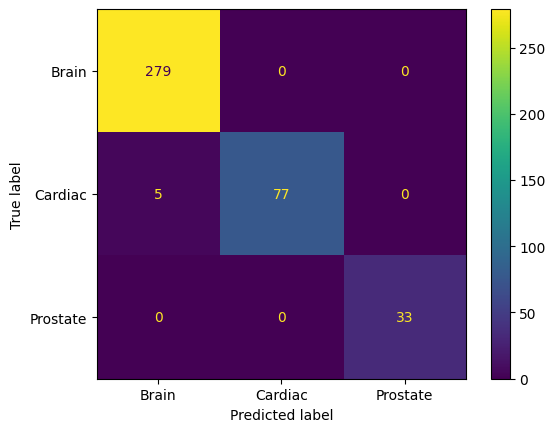

In [56]:
print(f"Train accuracy: {rf_classifier.score(X_dev_tf,y_dev)}")
y_pred = rf_classifier.predict(X_dev_tf)

cm = confusion_matrix(y_dev,y_pred)
disp = ConfusionMatrixDisplay(cm,display_labels=rf_classifier.classes_)
disp.plot()

In [29]:
err_df = dev.copy()[y_pred!=y_dev]
err_df["pred"] = y_pred[y_pred!=y_dev]
err_df

,title,doi,abstract,task,pred
424,A Generic Approach to Lung Field Segmentation ...,https://doi.org/10.1109/tbme.2019.2933508,computeraided diagnosis cad techniques for lun...,Cardiac,Brain
1375,Automatic Myocardial Infarction Evaluation fro...,https://doi.org/10.1007/978-3-030-68107-4_39,abstractin this paper we propose a new deep le...,Cardiac,Brain
530,Generation of annotated multimodal ground trut...,https://doi.org/10.1007/s11548-021-02372-7,sparsity of annotated data is a major limitati...,Cardiac,Brain
1000,Weakly Supervised Segmentation with Multi-scal...,None,large finegrained image segmentation datasets ...,Cardiac,Brain
2987,Segmentation tracking and cell cycle analysis ...,https://doi.org/10.1186/s12915-022-01372-6,abstract background highthroughput livecell im...,Cardiac,Brain


## One class classification with the same representation using one-class svm

In [30]:
from sklearn.svm import OneClassSVM

x_train_cardiac = vectorizer.transform(train[train["task"] == "Cardiac"]["abstract"].to_list())
x_train_brain = vectorizer.transform(train[train["task"] == "Brain"]["abstract"].to_list())
x_train_prostate = vectorizer.transform(train[train["task"] == "Prostate"]["abstract"].to_list())

x_dev_cardiac = vectorizer.transform(dev[dev["task"] == "Cardiac"]["abstract"].to_list())
x_dev_brain = vectorizer.transform(dev[dev["task"] == "Brain"]["abstract"].to_list())
x_dev_prostate = vectorizer.transform(dev[dev["task"] == "Prostate"]["abstract"].to_list())

for nu in [0.05,0.1,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.5]:
    print(f"\n=====================Nu: {nu}=====================")
    svm = OneClassSVM(nu=nu)
    print('Model for brain classification')
    svm.fit(x_train_brain)
    pred = svm.predict(x_dev_brain)
    print("Detection of brain task",sum(pred==1)/len(pred)*100)

    pred = svm.predict(x_dev_cardiac)
    print("Detection of ourlier with cardiac",sum(pred==-1)/len(pred)*100)

    pred = svm.predict(x_dev_prostate)
    print("Detection of outlier with prostate",sum(pred==-1)/len(pred)*100)

    print('\nModel for cardiac classification')
    svm.fit(x_train_cardiac)
    pred = svm.predict(x_train_cardiac)
    print("Detection of cardiac task",sum(pred==1)/len(pred)*100)

    pred = svm.predict(x_dev_brain)
    print("Detection of outlier with brain",sum(pred==-1)/len(pred)*100)

    pred = svm.predict(x_dev_prostate)
    print("Detection of outlier with prostate",sum(pred==-1)/len(pred)*100)

    print('\nModel for prostate classification')
    svm.fit(x_train_prostate)
    pred = svm.predict(x_train_prostate)
    print("Detection of prostate task",sum(pred==1)/len(pred)*100)

    pred = svm.predict(x_dev_cardiac)
    print("Detection of outlier with cardiac",sum(pred==-1)/len(pred)*100)

    pred = svm.predict(x_dev_brain)
    print("Detection of outlier with brain",sum(pred==-1)/len(pred)*100)



=====================Nu: 0.05=====================
Model for brain classification
Detection of brain task 89.6057347670251
Detection of ourlier with cardiac 39.02439024390244
Detection of outlier with prostate 54.54545454545454

Model for cardiac classification
Detection of cardiac task 89.57703927492447
Detection of outlier with brain 77.41935483870968
Detection of outlier with prostate 90.9090909090909

Model for prostate classification
Detection of prostate task 84.61538461538461
Detection of outlier with cardiac 97.5609756097561
Detection of outlier with brain 97.4910394265233

=====================Nu: 0.1=====================
Model for brain classification
Detection of brain task 86.37992831541219
Detection of ourlier with cardiac 46.34146341463415
Detection of outlier with prostate 69.6969696969697

Model for cardiac classification
Detection of cardiac task 87.46223564954683
Detection of outlier with brain 77.77777777777779
Detection of outlier with prostate 90.9090909090909

Mo